# Maldives 2040

Abbreviations:
air-conditioning  (AC) \
Seawater air conditioning (SWAC) \
Reverse Osmosis desalination (RO) \
Deep Seawater Cooling and Desalination (DSCD) 

## 2 METHODOLOGY                                       

In [1421]:
import itertools
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import ixmp
import message_ix

from message_ix.utils import make_df

In [1422]:
mp = ixmp.Platform()

In [1423]:
#scen = "baseline"
#version = 1
scenario = message_ix.Scenario(mp, model="Maldives energy model",
                               scenario='baseline', version='new')

### Time and Spatial Detail

Horizons: 2025, 2030, 2035, 2040.


In [1424]:
history = [2015]
horizon = [2020, 2025, 2030, 2035, 2040]
scenario.add_horizon(year= history + horizon, firstmodelyear=horizon[0])

In [1425]:
country = 'Maldives'
scenario.add_spatial_sets({'country': country})

In [1426]:
scenario.add_set("commodity", ["electricity", 'freshwater', 'cooling', 'other_electricity'])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ['oil_ppl', 'solar_pv_ppl', 'battery_ppl', 'ro_pl', 'appliances'])
scenario.add_set("mode", "standard")

### 2.1 Growth estimation

<AxesSubplot:title={'center':'Demand'}>

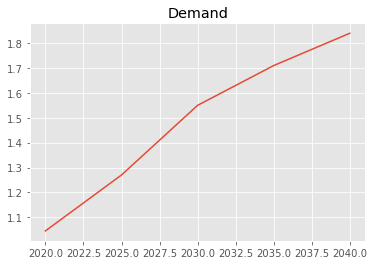

In [1427]:
#growth for years 2020, 2025, 2030, 2035, 2040
demand = pd.Series([1.045, 1.27, 1.55, 1.71, 1.84], index=horizon) # data from electricity growth from 2017 up to 2037
demand.plot(title='Demand')

In [1428]:
e_plants = [
    "battery_ppl",  #electricity plants
    "oil_ppl", 
    "solar_pv_ppl",
]
w_plants = [ 
    "ro_pl",  #desalination plant
]

secondary_energy_techs = e_plants + w_plants 

others = ['appliances'] #others electricity demand

useful_techs = ['ac', 'swac', 'dscd'] #+ others

In [1429]:
technologies = secondary_energy_techs + useful_techs
scenario.add_set("technology", technologies)

In [1430]:
df = scenario.par('demand')
scenario.remove_par('demand', df)

### 2.2 Demand for electricity, cooling and freshwater
Notice: that 1 MW of electricity (MWe) produces 0.1 m3/s of water and 20 MW of cooling

#### Units in MESSAGEix

In the MESSAGEix formulation, activity (generation) is related to capacity only with a capacity factor. So, there is no unit conversion possibility. And the values are per model year. This means, demand is defined as 100 GWh/a, and hence, the activity of a technology meeting this demand will be in the same unit, i.e., 100 GWh/a. Assuming a capacity factor of 1, the capacity of this technology will be 100 GWa/h (!). In a more familiar unit, 100 GWa/h is equal to 100 / 8760 = 0.0114 GW or simpler 11.4 MW. (check if you can reach to 100 GWh/a from 11.4 MW!?   ==>  11.4 \* 8760 \* 1 / 1000  = 100).

#### Solution:
As there is no unit check by MESSAGEix, an easy way is to assume a corresponding yearly unit for activity and capacity. For example, capacity GW and activity GWa. Or capacity MW and activity MWa, which we use here.

1 MWa = 8760 MWh = 8.76 GWh

In [1431]:
# Adding a new unit to the library
mp.add_unit('MW_th')
mp.add_unit('MWa/a')
mp.add_unit('MWa_th/a')
mp.add_unit('m^3/a')

ac_demand_per_year = (91800 * 3) / 8760 *5 # air conditiong energy demand in 2017 (MWh_th)
ac_demand = pd.DataFrame({
        'node': country,
        'commodity': 'cooling',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': ac_demand_per_year*demand,
        'unit': 'MWa_th/a',
    })
scenario.add_par("demand", ac_demand)

others_demand_per_year = 214200 / 8760 * 5.5
others_demand = pd.DataFrame({
        'node': country,
        'commodity': 'other_electricity',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': others_demand_per_year * demand,
        'unit': 'MWa/a',
    })
scenario.add_par("demand", others_demand)

freshwater_demand_per_year = 80000 * 365 #80,000 m^3/d
freshwater_demand = pd.DataFrame({
        'node': country,
        'commodity': 'freshwater',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': freshwater_demand_per_year * demand,
        'unit': 'm^3/a', 
    })
scenario.add_par("demand", freshwater_demand)   

INFO:root:unit `MW_th` is already defined in the platform instance
INFO:root:unit `MWa/a` is already defined in the platform instance
INFO:root:unit `MWa_th/a` is already defined in the platform instance
INFO:root:unit `m^3/a` is already defined in the platform instance


In [1432]:
print(ac_demand)

          node commodity   level  year  time       value      unit
2020  Maldives   cooling  useful  2020  year  164.265411  MWa_th/a
2025  Maldives   cooling  useful  2025  year  199.633562  MWa_th/a
2030  Maldives   cooling  useful  2030  year  243.647260  MWa_th/a
2035  Maldives   cooling  useful  2035  year  268.797945  MWa_th/a
2040  Maldives   cooling  useful  2040  year  289.232877  MWa_th/a


### 2.3 Engineering Parameters: inputs and outputs

In [1433]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act'] 

In [1434]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

In [1435]:
#others_electricity

app_in = make_df(base_input, technology='appliances', commodity='electricity',  
                  level='final', value=1., unit="MWa/a")
scenario.add_par('input', app_in)
app_out = make_df(base_output, technology='appliances', commodity='other_electricity', 
              level='useful', value=1., unit="MWa/a")
scenario.add_par('output', app_out)

In [1436]:
#air conditioning
ac_in = make_df(base_input, technology='ac', commodity='electricity',  
                  level='final', value=1., unit="MWa/a")
scenario.add_par('input', ac_in)
ac_out = make_df(base_output, technology='ac', commodity='cooling', 
                   level='useful', value=10., unit='MWa_th/a')
scenario.add_par('output', ac_out)

### Notice:
If the capacity of SWAC is given per electricity input, keep the input 1 and change the output relative to input, i.e., output = 20.
But if the capacity of SWAC is given per output thermal power, e.g., they say this machine is 20 MW_th; then you need to make the ouput = 1, and change the input relative to output. So, the input will be 1/20 MW, which is electricity needed for generating 1 MW_th.

Here, we assume that the size and cost of technology is communicated based on input electric capacity:

In [1437]:
# Seawater air conditioning (swac)
swac_in = make_df(base_input, technology='swac', commodity='electricity',  
                  level='final', value=1., unit="MWa/a")
scenario.add_par('input', swac_in)
swac_out = make_df(base_output, technology='swac', commodity='cooling', 
                   level='useful', value=20, unit='MWa_th/a')
scenario.add_par('output', swac_out)

In [1438]:
#secondary to useful w_tec
#reverse osmosis - water demand (row)
ro_in = make_df(base_input, technology='ro_pl', commodity='electricity',  
                  level='final', value=1, unit="MWa/a")
scenario.add_par('input', ro_in)
ro_out = make_df(base_output, technology='ro_pl', commodity='freshwater', 
                   level='useful', value=0.1 * 3600 * 8760, unit="m^3/a")   # 0.1 m^3/s = 0.1*3600 m^3/h = 0.1*3600*8760 m^3/a 
scenario.add_par('output', ro_out)

In [1439]:
ro_out

,node_loc,year_vtg,year_act,mode,time,unit,node_dest,time_dest,technology,commodity,level,value
0,Maldives,2015,2020,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0
1,Maldives,2015,2025,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0
2,Maldives,2015,2030,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0
3,Maldives,2015,2035,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0
4,Maldives,2015,2040,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0
5,Maldives,2020,2020,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0
6,Maldives,2020,2025,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0
7,Maldives,2020,2030,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0
8,Maldives,2020,2035,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0
9,Maldives,2020,2040,standard,year,m^3/a,Maldives,year,ro_pl,freshwater,useful,3153600.0


In [1440]:
#dscd
#deep seawater cooling and desalination - cooling demand (dscdc)

dscdc_in = make_df(base_input, technology='dscd', commodity='electricity',  
                  level='final', value=1., unit="MWa/a")
scenario.add_par('input', dscdc_in)
dscdc_out = make_df(base_output, technology='dscd', commodity='cooling', 
                   level='useful', value=20, unit="MWa_th/a")
scenario.add_par('output', dscdc_out)
dscdw_out = make_df(base_output, technology='dscd', commodity='freshwater', 
                   level='useful', value=0.1 * 3600 * 8760, unit="m^3/a") 
scenario.add_par('output', dscdw_out)

In [1441]:
#secondary to useful e_tecs

oil_out = make_df(base_output, technology='oil_ppl', commodity='electricity', 
                   level='final', value=1., unit="MWa/a")
scenario.add_par('output', oil_out)

solar_pv_out = make_df(base_output, technology='solar_pv_ppl', commodity='electricity', 
                   level='final', value=1., unit="MWa/a")
scenario.add_par('output', solar_pv_out)

battery_out = make_df(base_output, technology='battery_ppl', commodity='electricity', 
                   level='final', value=1., unit="MWa/a")
scenario.add_par('output', battery_out)

### 2.4 Operational Constraints and Parameters

In [1442]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

capacity_factor = {
    'oil_ppl': 0.75,
    'battery_ppl': 0.3, 
    'solar_pv_ppl': 0.3,
    'ac': 0.8,
    'ro_pl': 0.8,
    'swac': 0.8, 
    'dscd': 0.8, 
    'appliances': 0.5
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

In [1443]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': horizon,
    'unit': 'y',
}

lifetimes = {
    'oil_ppl': 30,
    'battery_ppl': 5,
    'solar_pv_ppl': 20,
    'ac': 15,
    'ro_pl': 40,
    'swac': 40, 
    'dscd': 40, 
    'appliances': 10
}

for tec, val in lifetimes.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

### 2.5 Technological Diffusion and Contraction

In [1444]:
base_growth = {
    'node_loc': country,
    'year_vtg': horizon,
    'time': 'year',
    'unit': '-',
}

In [1445]:
growth_technologies = {
    "solar_pv_ppl": 2, 
    "swac": 0.1,
    "dscd": 0.1,
}

for tec, val in growth_technologies.items():
    df = make_df(base_growth, technology=tec, value=val) 
    scenario.add_par('growth_new_capacity_up', df)

In [1446]:
hist_e_gen = others_demand_per_year + ac_demand_per_year/3
hist_c_gen = ac_demand_per_year/3
hist_w_gen = freshwater_demand_per_year

In [1447]:
hist_c_gen

52.3972602739726

In [1448]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': '-',
}

base_activity = {
    'node_loc': country,
    'year_vtg': history,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

In [1449]:
old_activity = {
    'solar_pv_ppl': .05*hist_e_gen,
    'oil_ppl': .95*hist_e_gen,
    'ac':  .98* hist_c_gen,
    'swac': .01 * hist_c_gen,
    'dscd': .01 * hist_c_gen,
    'ro_pl': .99*hist_w_gen,
        
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('initial_new_capacity_up', df)

In [1450]:
act_to_cap = {
    'solar_pv_ppl': 1 / 10 / capacity_factor['solar_pv_ppl'] / 2, # 20 year lifetime
    'swac': 1 / 10 / capacity_factor['swac']/2,
    'dscd': 1 / 10/ capacity_factor['dscd']/2,    
    'ac': 1 / 10/ capacity_factor['ac']/2
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scenario.add_par('historical_new_capacity', df)

In [1451]:
scenario.add_par("interestrate", horizon, value=0.05, unit='-')

### 2.6 Technoeconomic Parameters
Because we use the unit of MW for capacity, we should be careful with the cost units.

1 \\$/kW = 1000 \\$/MW = 1 k\\$/MW

So, we use k$/MW (thousands dollars per MW), and we don't have to change the numbers.

In [1452]:
mp.add_unit('k$/MW')
base_inv_cost = {
    'node_loc': country,
    'year_vtg': horizon, 
    'unit': 'k$/MW',
}

costs = {
    'oil_ppl': 950, #value from Austria baseline model 
    'battery_ppl': 450, #value from MESSAGE-BRAZIL baseline 
    'solar_pv_ppl': 677, #value from IEA for India in 2019
    'ac': 25, #average price for commercial buildings in USA
    'ro_pl': 950, # in this case it is USD/km³ 
    'swac': 1000,#42000, # USD/kW
    'dscd': 950 + 1000,#42000, 
    'appliances': 50
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

INFO:root:unit `k$/MW` is already defined in the platform instance


In [1453]:
mp.add_unit('k$/MW/a')
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'k$/MW/a',
}


costs = {
    'oil_ppl': 0,#25, #value from Austria baseline model 
    'battery_ppl': 0,#32, #value from MESSAGE-BRAZIL baseline
    'solar_pv_ppl': 0,#5, #value from MESSAGE-BRAZIL baseline
    'ac': 0,#30, 
    'ro_pl': 0,#280,
    'swac': 0,#195., 
    'dscd': 0,#(280+195)*0.7, 
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

INFO:root:unit `k$/MW/a` is already defined in the platform instance


And now we need to change USD/kWa to k\\$/MWa... yes, we don't need to change the numbers, because these units are equal!

In [1454]:
mp.add_unit('k$/MWa')
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'k$/MWa',
}

costs = {
    'oil_ppl': 77.8, #value from Austria baseline model 
    'battery_ppl': 0, #value from MESSAGE-BRAZIL baseline
    'solar_pv_ppl': 0, #value from MESSAGE-BRAZIL baseline
    'ro_pl': 0,
    'swac': 0., 
    'ac': 0., 
    #'appliances': 0.
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val) 
    scenario.add_par('var_cost', df)

INFO:root:unit `k$/MWa` is already defined in the platform instance


### Emissions

How about the unit of emissions?

0.57 kg/kWh = 0.57 t/MWh = 0.57 * 8760 t/MWa

so we need to change the number here:

In [1455]:
scenario.add_set('emission', 'CO2')
scenario.add_cat('emission', 'GHG', 'CO2')

# we now add CO2 emissions to the coal powerplant
base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/MWa',
}

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/MWa')
mp.add_unit('MtCO2')

emission_factor = make_df(base_emission_factor, technology= 'oil_ppl', emission= 'CO2', value = 0.57 * 8760)
scenario.add_par('emission_factor', emission_factor)

INFO:root:unit `tCO2/MWa` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance


### Commit the datastructure and solve the model

In [1456]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scenario.version))
scenario.commit(comment='basic model of Maldives')
log.info('version number prior committing to the database: {}'.format(scenario.version))

INFO:message_ix:version number prior to commit: 0
INFO:message_ix:version number prior committing to the database: 30


In [1457]:
scenario.set_as_default()

In [1458]:
scenario.solve()

In [1459]:
scenario.var('OBJ')['lvl']

493635.46875

### Let's review the units!!
I know it's a bit confusing. So, let's remember the units before moving to the results:

capacity = MW

activity (generation) = MWa

CO2 emissions = tonne of CO2

costs = k\\$ (thousands dollar)

## 3. Plotting Results

In [1460]:
import pyam
from ixmp.reporting import configure
from message_ix.reporting import Reporter
import os
import matplotlib.pyplot as plt
configure(units={'replace': {'-': 'MWa'}})

In [1461]:
rep = Reporter.from_scenario(scenario)

In [1462]:
# plotting years
plotyrs = [x for x in set(scenario.set('year')) if x >= scenario.firstmodelyear]

In [1463]:
rep.set_filters(c = 'cooling')
cool = rep.full_key('out')
cool = cool.drop('yv','m','nd','hd','h')
cool_gen = rep.get(cool)
cool_gen

nl        t     ya    c        l     
Maldives  ac    2020  cooling  useful    150.587054
                2025  cooling  useful    172.364705
                2030  cooling  useful    194.490767
                2035  cooling  useful    184.391196
                2040  cooling  useful    148.055236
          dscd  2020  cooling  useful      6.839179
                2025  cooling  useful     13.634429
                2030  cooling  useful     24.578247
                2035  cooling  useful     42.203375
                2040  cooling  useful     70.588820
          swac  2020  cooling  useful      6.839179
                2025  cooling  useful     13.634429
                2030  cooling  useful     24.578247
                2035  cooling  useful     42.203375
                2040  cooling  useful     70.588820
dtype: float64

In [1464]:
rep.set_filters(c = 'electricity')
elec = rep.full_key('out')
elec = elec.drop('yv','m','nd','hd','h')
elec_gen = rep.get(elec)
elec_gen

nl        t             ya    c            l    
Maldives  battery_ppl   2020  electricity  final      0.000000
                        2025  electricity  final      0.000000
                        2030  electricity  final      0.000000
                        2035  electricity  final      0.000000
                        2040  electricity  final      0.000000
          oil_ppl       2020  electricity  final    163.278731
                        2025  electricity  final    198.139009
                        2030  electricity  final    241.147564
                        2035  electricity  final    266.354197
                        2040  electricity  final    282.826796
          solar_pv_ppl  2020  electricity  final      2.336045
                        2025  electricity  final      2.336045
                        2030  electricity  final      2.336045
                        2035  electricity  final      0.000000
                        2040  electricity  final      0.000000
dtype:

In [1465]:
rep.set_filters(c = 'freshwater')
wat = rep.full_key('out')
wat = wat.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

nl        t      ya    c           l     
Maldives  dscd   2020  freshwater  useful    1.078402e+06
                 2025  freshwater  useful    2.149877e+06
                 2030  freshwater  useful    3.875498e+06
                 2035  freshwater  useful    6.654628e+06
                 2040  freshwater  useful    1.113045e+07
          ro_pl  2020  freshwater  useful    2.943560e+07
                 2025  freshwater  useful    3.493412e+07
                 2030  freshwater  useful    4.138450e+07
                 2035  freshwater  useful    4.327737e+07
                 2040  freshwater  useful    4.259755e+07
dtype: float64

In [1466]:
rep.set_filters(c = 'other_electricity')
wat = rep.full_key('out')
wat = elec.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

nl        t           ya    c                  l     
Maldives  appliances  2020  other_electricity  useful    140.538185
                      2025  other_electricity  useful    170.797603
                      2030  other_electricity  useful    208.453767
                      2035  other_electricity  useful    229.971575
                      2040  other_electricity  useful    247.454795
dtype: float64

In [1467]:
# For electricity generation, I filter out electr commodity and report output to see only electricity output here 
# This filter can be changed for any other commdodity too 
rep.set_filters(c = 'electricity')
elec = rep.full_key('out')
elec = elec.drop('yv','m','nd','hd','h')
elec_gen = rep.get(elec)
elec_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=elec,
        rename=dict(nl='region', ya='year'),
        collapse=collapse_callback)
    
df_elec = rep.get(new_key)
df_elec.data.unit = 'MWa'
df_elec.to_csv('electricity_2.csv')

TypeError: convert_pyam() got an unexpected keyword argument 'rename'

In [1468]:
elec_gen = pd.read_csv("electricity_2.csv")
elec_gen.columns 

FileNotFoundError: [Errno 2] No such file or directory: 'electricity_2.csv'

In [ ]:
# Loading data from csv into a pyam format
elec_gen = pyam.IamDataFrame(data='electricity_2.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
elec_gen.data

In [1469]:
elec = elec_gen.filter(region=['Maldives'], variable='Electricity Generation|final|*', year=plotyrs)
elec.plot.bar(stacked=True)

TypeError: filter() got an unexpected keyword argument 'region'

In [ ]:
rep.set_filters(c = 'cooling')
cool = rep.full_key('out')
cool = cool.drop('yv','m','nd','hd','h')
cool_gen = rep.get(cool)
cool_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=cool,
        rename=dict(nl='region', ya='year'),
        collapse=collapse_callback)
    
df_cool = rep.get(new_key)
df_cool.data.unit = 'MWa'
df_cool.to_csv('cooling.csv')

In [1470]:
elec_gen = pd.read_csv("cooling.csv")
elec_gen.columns 

FileNotFoundError: [Errno 2] No such file or directory: 'cooling.csv'

In [ ]:
# Loading data from csv into a pyam format
cool_gen = pyam.IamDataFrame(data='cooling.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
cool_gen.data

In [1471]:
cool = cool_gen.filter(region=['Maldives'], variable='Electricity Generation|useful|*', year=plotyrs)
cool.plot.bar(stacked=True)

TypeError: filter() got an unexpected keyword argument 'region'

In [1472]:
rep.set_filters(c = 'freshwater')
wat = rep.full_key('out')
wat = wat.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=wat,
        rename=dict(nl='region', ya='year'),
        collapse=collapse_callback)
    
df_wat = rep.get(new_key)
df_wat.data.unit = 'm^3'
df_wat.to_csv('freshwater.csv')

TypeError: convert_pyam() got an unexpected keyword argument 'rename'

In [1473]:
elec_gen = pd.read_csv("freshwater.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'freshwater.csv'

In [ ]:
# Loading data from csv into a pyam format
wat_gen = pyam.IamDataFrame(data='freshwater.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
wat_gen.data

In [1474]:
wat = wat_gen.filter(region=['Maldives'], variable='Electricity Generation|useful|*', year=plotyrs)
wat.plot.bar(stacked=True)

TypeError: filter() got an unexpected keyword argument 'region'

In [1475]:
mp.close_db()